In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.animation as animation
from IPython.display import Image

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Loading the data we are going to visualise:

In [4]:
df_merged = pd.read_csv('/Users/lderosa/Desktop/fire model/data/processed/fires_merged_FILE.csv')


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_13036/461948839.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv('/Users/lderosa/Desktop/fire model/data/processed/fires_merged_FILE.csv')


Load fires inside cells:

In [5]:
fires_in_cells = pd.read_csv('/Users/lderosa/Desktop/fire model/data/processed/fires_in_cells_FILE.csv')

/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_13036/340643682.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  fires_in_cells = pd.read_csv('/Users/lderosa/Desktop/fire model/data/processed/fires_in_cells_FILE.csv')


Load grid:

In [6]:
grid_4326 = gpd.read_file('/Users/lderosa/Desktop/fire model/data/processed/grid_4326_FILE.GeoJSON')
grid_3857 = gpd.read_file('/Users/lderosa/Desktop/fire model/data/processed/grid_3857_FILE.GeoJSON')

### Sample of the enriched modelling dataset
This snapshot highlights the columns we engineered for modelling (climate features, lags, label, split).

In [3]:
enriched_df = pd.read_csv('outputs/training_base_enriched_power.csv', parse_dates=['month'])

columns_to_show = ['cell_id', 'month', 'temp2m_mean_c', 'precip_sum_mm', 'fire_last_month', 'lag2', 'fire_occurred', 'data_split']
pretty_sample = (
    enriched_df
        .assign(month=lambda d: d['month'].dt.strftime('%Y-%m'))
        [columns_to_show]
        .sample(8, random_state=42)
        .sort_values(['data_split', 'cell_id', 'month'])
)

styled_sample = (
    pretty_sample
        .style
        .format({
            'temp2m_mean_c': '{:.1f}',
            'precip_sum_mm': '{:.1f}',
            'fire_last_month': '{:.0f}',
            'lag2': '{:.0f}'
        })
        .background_gradient(subset=['temp2m_mean_c'], cmap='coolwarm')
        .background_gradient(subset=['precip_sum_mm'], cmap='Blues')
        .set_properties(subset=['data_split'], **{'font-weight': 'bold'})
        .set_caption('Example rows from outputs/training_base_enriched_power.csv')
)
styled_sample

,cell_id,month,temp2m_mean_c,precip_sum_mm,fire_last_month,lag2,fire_occurred,data_split
3448,1513,2024-10,12.2,3.9,0,0,0,test
45093,4370,2022-04,12.0,1.4,0,0,0,train
70402,5804,2023-04,12.3,1.0,1,2,1,train
98712,6995,2021-11,11.3,4.7,0,0,0,train
120540,7829,2023-08,26.5,0.4,1,2,1,train
208218,11817,2021-05,18.1,0.2,0,0,1,train
69188,5716,2023-11,-1.2,2.9,0,0,0,validation
74547,6007,2023-12,8.9,0.6,0,0,0,validation


### From Data to GeoData!

In [4]:

monthly_counts = df_merged.groupby('un_month').size()
monthly_counts.plot()

NameError: name 'df_merged' is not defined

<Axes: xlabel='un_week'>

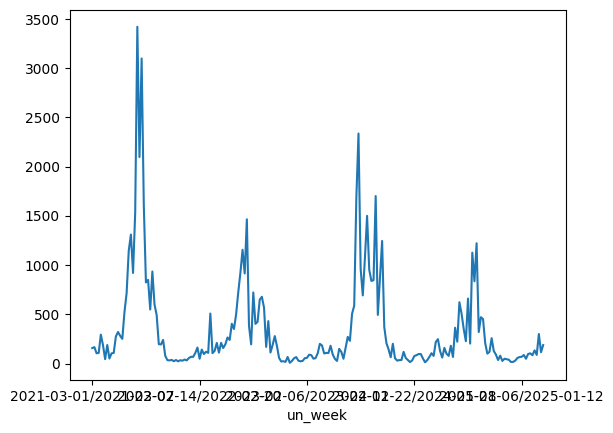

In [ ]:
weekly_counts = df_merged.groupby('un_week').size()
weekly_counts.plot()

Note how to visualise a grid. Just `.plot()` won't do the job.

<Axes: >

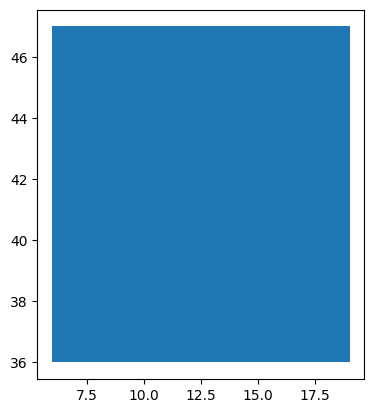

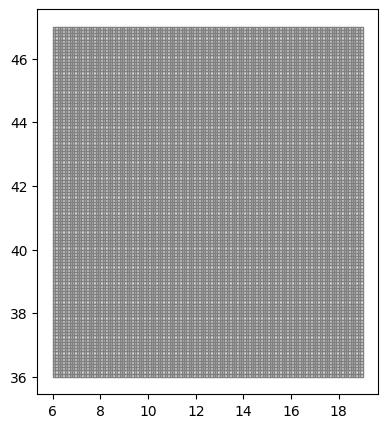

In [ ]:
grid_4326.plot()
grid_4326.plot(edgecolor="grey", facecolor="none", figsize=(5, 5))

<Axes: >

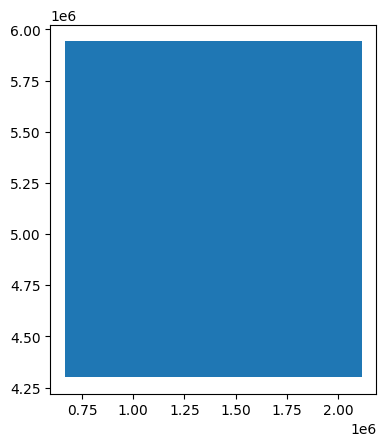

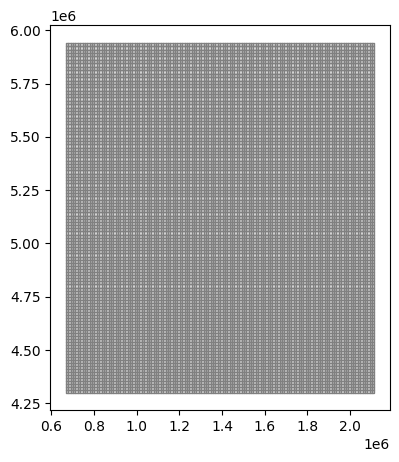

In [ ]:
grid_3857.plot()
grid_3857.plot(edgecolor="grey", facecolor="none", figsize=(5, 5))

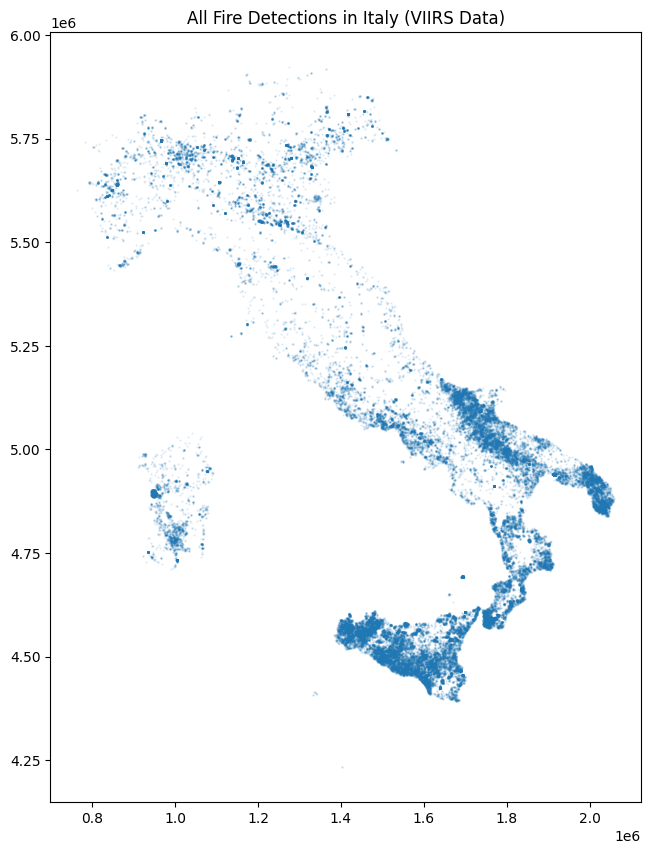

In [ ]:

# Create geometry column from lat/lon
geometry = [Point(xy) for xy in zip(df_merged.longitude, df_merged.latitude)]

# Create GeoDataFrame
gdf_fires = gpd.GeoDataFrame(df_merged, geometry=geometry, crs="EPSG:4326")
# We change to the coordinate system 3857 because it is going to be more
# convenient when using contexily
gdf_fires = gdf_fires.to_crs(epsg=3857) # FROM NOW ON FOR VISUALISATIONS WE USE 3857 PROJECTION!!

# Basic plot of all fire points
fig, ax = plt.subplots(figsize=(10, 10))
gdf_fires.plot(ax=ax, markersize=0.5, alpha=0.1)
ax.set_title("All Fire Detections in Italy (VIIRS Data)")
plt.show()

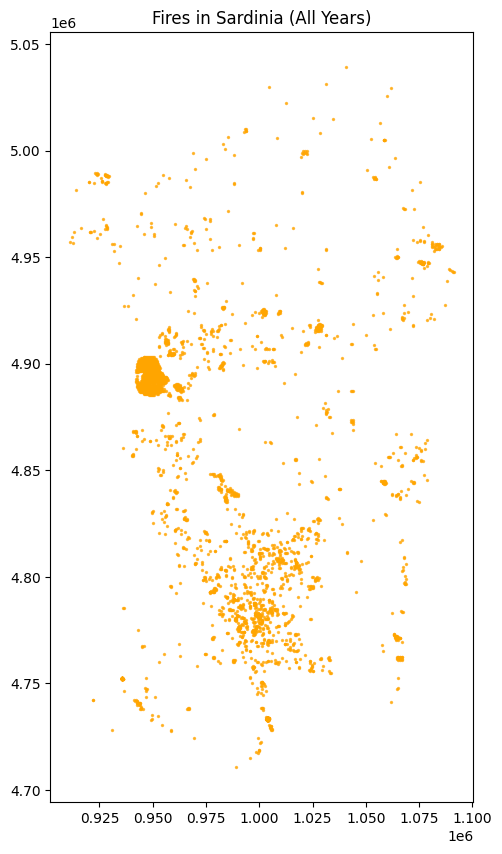

In [ ]:
# Filter by aerea

# Use .cx to spatially filter using bounding box
mmix, mmax, mmiy, mmay = 0.8*10**6, 1.2*10**6, 4.5*10**6, 5.25*10**6

sardinia_fires = gdf_fires.cx[mmix:mmax, mmiy:mmay]

# Plot fires in Sicily
fig, ax = plt.subplots(figsize=(10, 10))
sardinia_fires.plot(ax=ax, markersize=2, color='orange', alpha=0.7)
ax.set_title("Fires in Sardinia (All Years)")
plt.show()


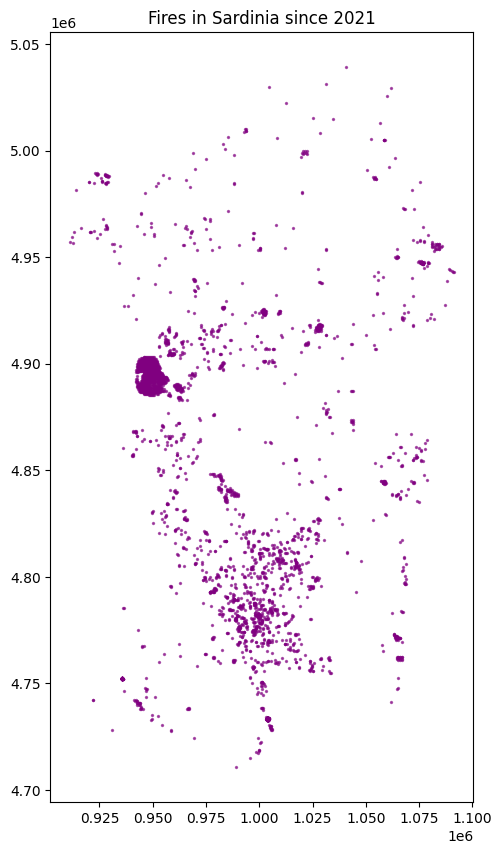

In [ ]:
sardinia_2021 = gdf_fires[
    (gdf_fires['datetime'] >= '2021-01-01 00:00:00') &
    (gdf_fires['longitude'].between(6, 12)) &
    (gdf_fires['latitude'].between(38, 42))
]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sardinia_2021.plot(ax=ax, markersize=2, color='purple', alpha=0.6)
ax.set_title("Fires in Sardinia since 2021")
plt.show()


<Axes: title={'center': 'Fires per year'}, xlabel='year'>

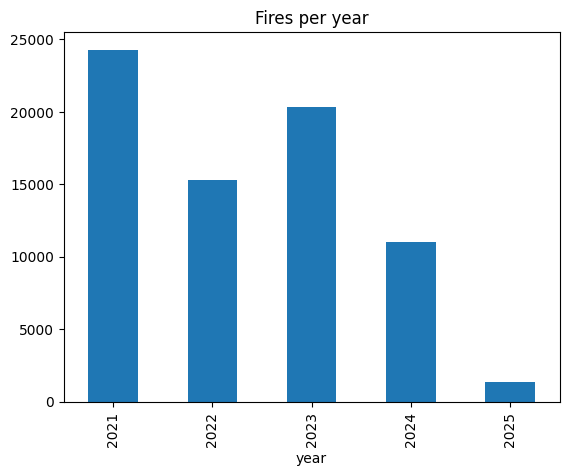

In [ ]:
df_merged['year'].value_counts().sort_index().plot(kind = 'bar', title = 'Fires per year')

<Axes: title={'center': 'Fires per month'}, xlabel='month'>

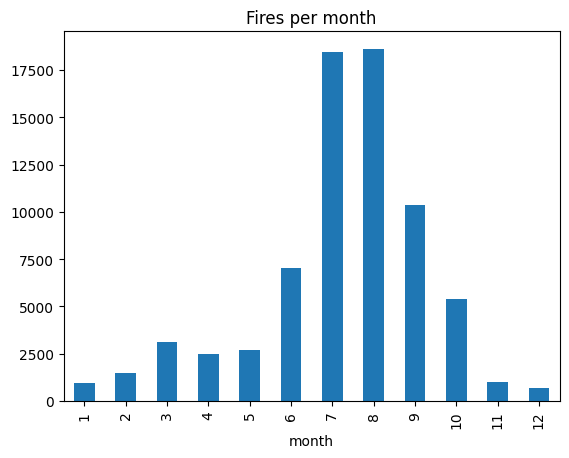

In [ ]:
df_merged['month'].value_counts().sort_index().plot(kind = 'bar', title = 'Fires per month')

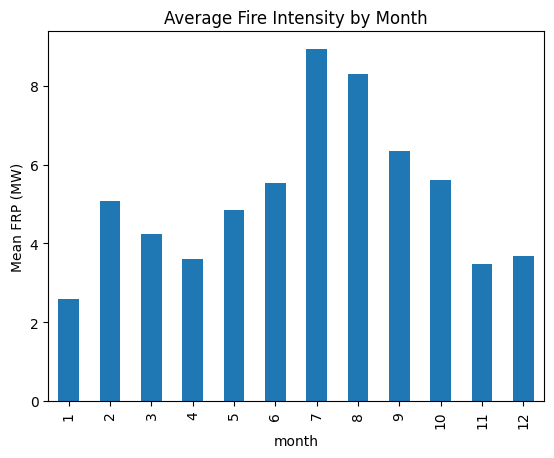

In [ ]:
df_merged.groupby('month')['frp'].mean().plot(kind='bar', title="Average Fire Intensity by Month")
plt.ylabel("Mean FRP (MW)")
plt.show()

Let's use the `ctx` library to add an underlying map of italy. We take it from CartoDB. Other sources could be OpenStreetMap and ESRI WorldGreyCanvas.

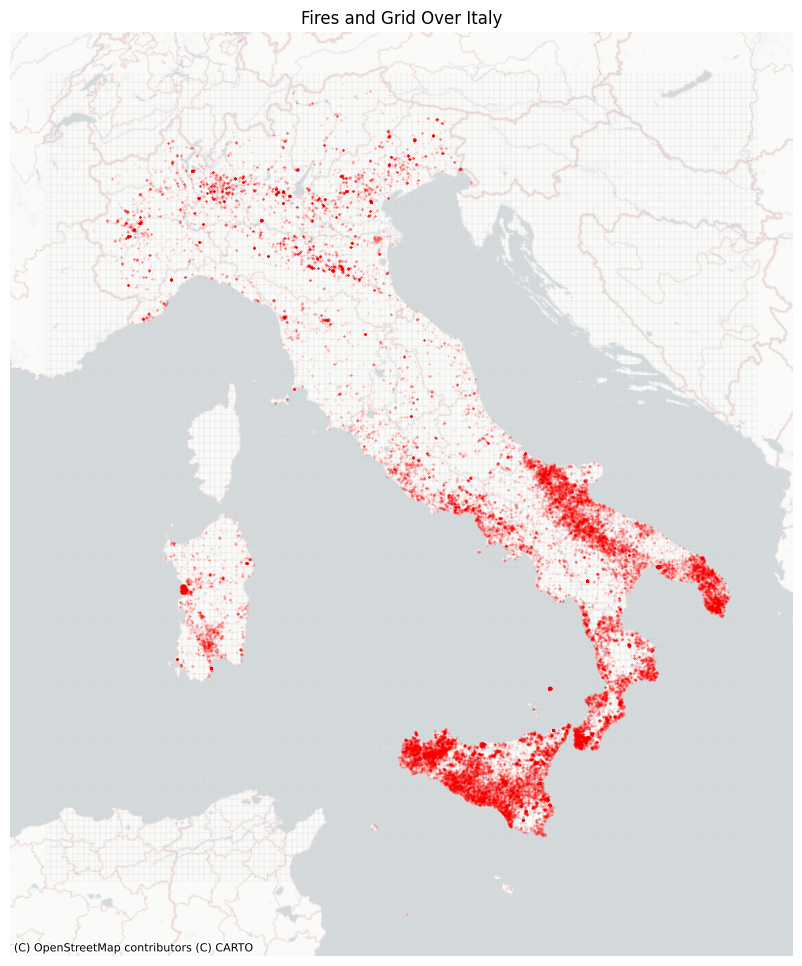

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
grid_3857.plot(ax=ax, facecolor="none", edgecolor="lightgrey", linewidth=0.1)
gdf_fires.plot(ax=ax, color="red", markersize=0.1, alpha=0.2)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)

plt.title("Fires and Grid Over Italy")
plt.axis("off")

plt.show()


Now we load the data describing fires inside cells, and visualise it.

In [ ]:
cell_ids_march_2021 = fires_in_cells.loc[fires_in_cells['un_month'] == '2021-03', 'cell_id'].unique()
print(cell_ids_march_2021)

[ 2503  6583  9727  8929 11692 11819  9188  6334  5897 10277 12039  9509
  6922  3604  2295  2957 12475 13246  8959  9076  8420 10142 10924 11035
 11694 11912 12023 11467 10925 10270 10817  7210  8647  6335  2185 13136
 11142 11356  3330  9914 11913 11362 11800 11469  8049 10140  8265 11019
  8703 11140 11135  8312  9403  3889 10605 10825 11253 12584  8430 12255
  8413 11034  9838  9619 11051  9839 12038 12035 11377 13134 12474 11579
  9513  9301 10724  9247 10284  9739  3506  5585 11247 11025 11245 11133
  9512 10916  8270  5688  1961  3176  3946  4276  3505  6475  5813  3057
  4934  9591  6036  6145  6146  9917 10026 10027 10136  6035  2846  5593
  7325  9807  9691  9810  9805  7826  9148  3222  3342  6900  5039  2617
  3279  1630  2072  1740  5698  5259  5365  5695  5369  5258  4928  5366
  6988 10833 12134  3614  9695  8044 10803  9809  9800 10139 11705 11242
 11468 11575  8158 11156  3507  5925  3726  2739  1852  2629  3835  5594
  1843 11799  3842  2734  2843  1631  3725 11914  5

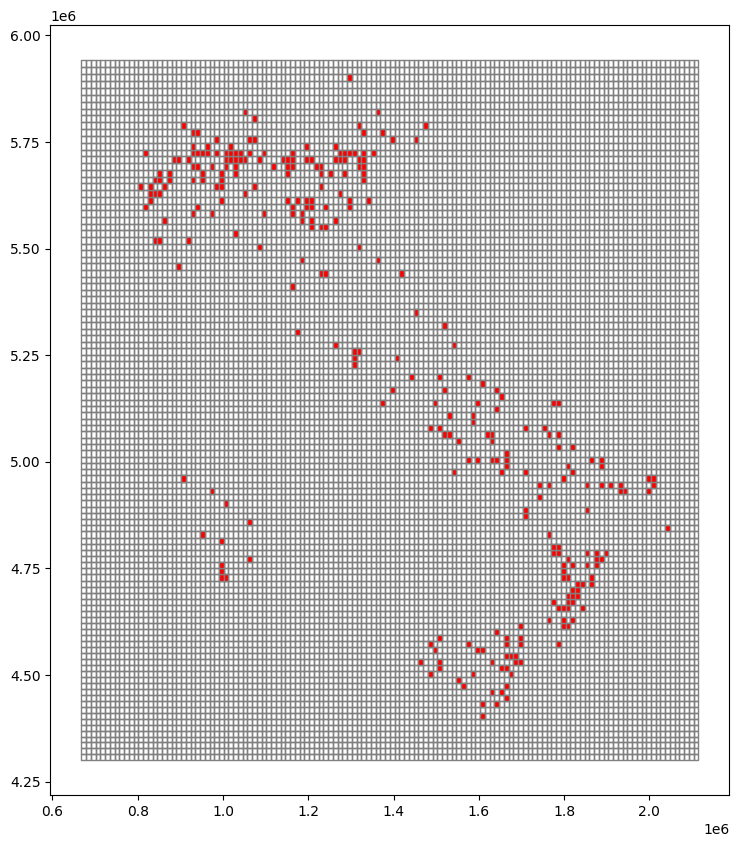

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

grid_3857.plot(ax = ax, edgecolor="grey", facecolor="none", figsize=(10, 10))
filtered_cells = grid_3857[grid_3857['cell_id'].isin(cell_ids_march_2021)]
filtered_cells.plot(ax = ax, color='red', edgecolor = 'grey')

plt.show()

In [ ]:

months = sorted(fires_in_cells['un_month'].unique())
fig, ax = plt.subplots(figsize=(10, 10))

def update(month):
    ax.clear()
    cell_ids = fires_in_cells.loc[fires_in_cells['un_month'] == month, 'cell_id'].unique()
    filtered = grid_3857[grid_3857['cell_id'].astype(str).isin(cell_ids.astype(str))]

    grid_3857.plot(ax=ax, edgecolor="grey", facecolor="none")
    filtered.plot(ax=ax, color='red', edgecolor='grey')
    
    ax.set_title(f"Fires in {str(month)}", fontsize=14)
    ax.set_axis_off()

ani = animation.FuncAnimation(fig, update, frames=months, repeat=False)

# Save as GIF
ani.save("grid_fires_animation.gif", writer="pillow", fps=3)
plt.close(fig)



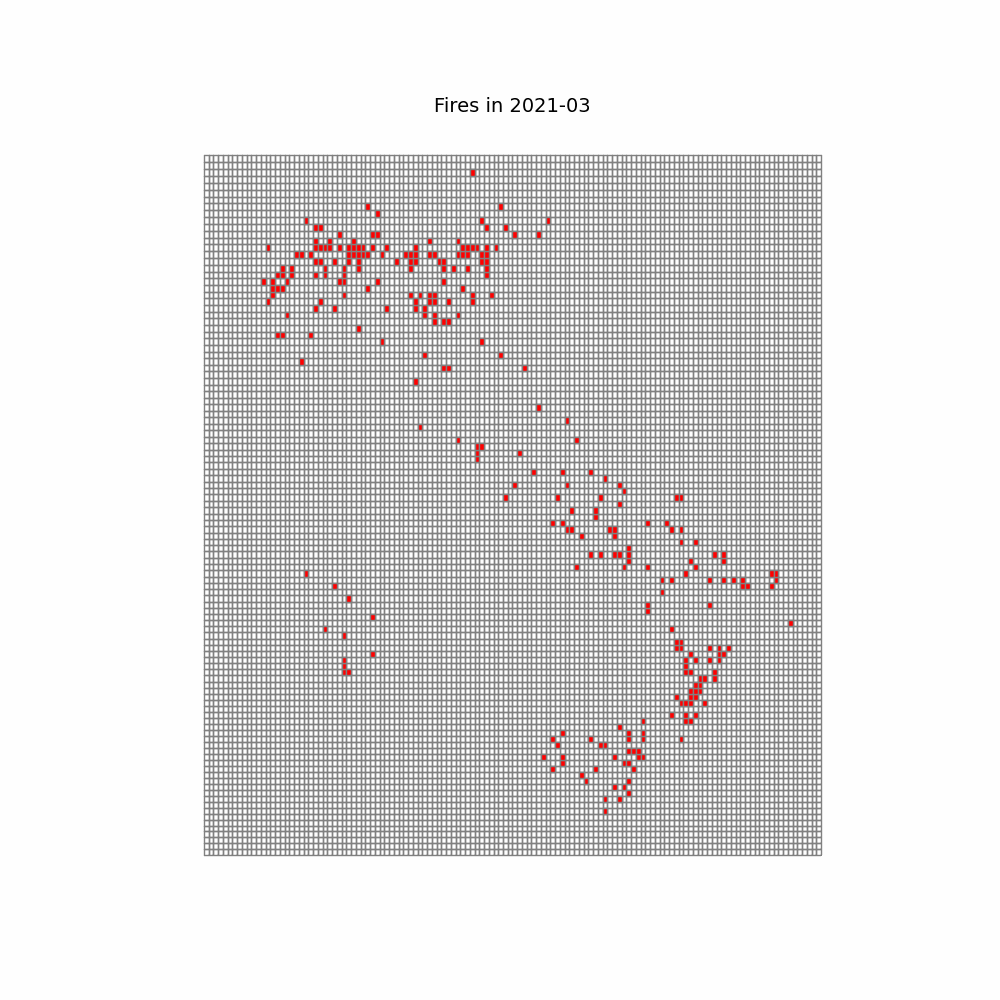

In [ ]:
Image(filename="grid_fires_animation.gif")
